In [26]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import torch as th
from sklearn.model_selection import train_test_split

In [27]:
# Define the input directory
input_dir = os.path.join("..", "inputs", "example_02e")

In [28]:
# @title Load observations function


def load_observations(path, feature_names):
    # Load observations
    obs_path = f"{path}/buffer_obs.json"

    with open(obs_path) as file:
        json_data = json.load(file)

    # Convert the list of lists into a 2D numpy array
    input_data = np.array(json_data)

    # Take only the first entry of the second dimension if shape is (N, 2, 74)
    if input_data.ndim == 3 and input_data.shape[1] == 2:
        input_data = input_data[:, 0, :]
    else:
        input_data = np.squeeze(input_data)

    # filter out arrays where all value are 0
    input_data = input_data[~np.all(input_data == 0, axis=1)]

    return pd.DataFrame(input_data, columns=feature_names), input_data

In [29]:
# path to extra loggedobservation values
path = input_dir + "/learned_strategies/example_02e_base_economic_value"

In [30]:
# Define feature names (replace with actual feature names)
# make columns names
names_1 = ["residual load forecast t+" + str(x) for x in range(1, 25)]
names_2 = ["price forecast t+" + str(x) for x in range(1, 25)]
names_3 = ["historical prices t+" + str(x) for x in range(1, 25)]
feature_names = names_1 + names_2 + names_3 + ["SoC t-1"] + ["energy costs t"]

df_obs, input_data = load_observations(path, feature_names)

df_obs

,residual load forecast t+1,residual load forecast t+2,residual load forecast t+3,residual load forecast t+4,residual load forecast t+5,residual load forecast t+6,residual load forecast t+7,residual load forecast t+8,residual load forecast t+9,residual load forecast t+10,...,historical prices t+17,historical prices t+18,historical prices t+19,historical prices t+20,historical prices t+21,historical prices t+22,historical prices t+23,historical prices t+24,SoC t-1,energy costs t
0,0.371769,0.349893,0.354110,0.394960,0.485614,0.673322,0.804380,0.875515,0.901607,0.937869,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.349893,0.354110,0.394960,0.485614,0.673322,0.804380,0.875515,0.901607,0.937869,0.958803,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.557083,0.0,0.0,0.0
2,0.354110,0.394960,0.485614,0.673322,0.804380,0.875515,0.901607,0.937869,0.958803,0.935810,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.557083,0.391562,0.0,0.0,0.0
3,0.394960,0.485614,0.673322,0.804380,0.875515,0.901607,0.937869,0.958803,0.935810,0.899573,...,0.000000,0.000000,0.000000,0.000000,0.557083,0.391562,0.391562,0.0,0.0,0.0
4,0.485614,0.673322,0.804380,0.875515,0.901607,0.937869,0.958803,0.935810,0.899573,0.854531,...,0.000000,0.000000,0.000000,0.557083,0.391562,0.391562,0.557083,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25879,0.620393,0.613250,0.563098,0.510814,0.442110,0.338881,0.280396,0.223300,0.410958,0.371769,...,0.677083,0.677083,0.677083,0.677083,0.677083,0.677083,0.617083,0.0,0.0,0.0
25880,0.613250,0.563098,0.510814,0.442110,0.338881,0.280396,0.223300,0.410958,0.371769,0.349893,...,0.677083,0.677083,0.677083,0.677083,0.677083,0.617083,0.617083,0.0,0.0,0.0
25881,0.563098,0.510814,0.442110,0.338881,0.280396,0.223300,0.410958,0.371769,0.349893,0.354110,...,0.677083,0.677083,0.677083,0.677083,0.617083,0.617083,0.617083,0.0,0.0,0.0
25882,0.510814,0.442110,0.338881,0.280396,0.223300,0.410958,0.371769,0.349893,0.354110,0.394960,...,0.677083,0.677083,0.677083,0.617083,0.617083,0.617083,0.617083,0.0,0.0,0.0


In [31]:
from assume.reinforcement_learning.neural_network_architecture import MLPActor

# Initialize the model
obs_dim = len(feature_names)
act_dim = 1  # Adjust if your model outputs a different number of actions
model = MLPActor(obs_dim=obs_dim, act_dim=act_dim, float_type=th.float)

In [32]:
# which actor is the RL actor
ACTOR_NUM = 1  # 20

# Path to actor we want to analyse
actor_path = os.path.join(
    input_dir,
    f"learned_strategies/example_02e_base/avg_reward_eval_policies/actors/actor_Storage {ACTOR_NUM}.pt",
)

# Load the trained model parameters
model_state = th.load(actor_path, map_location=th.device("cpu"))
model.load_state_dict(model_state["actor"])

<All keys matched successfully>

In [33]:
actions = []
for obs in input_data:
    obs_tensor = th.tensor(obs, dtype=th.float)
    action = model(obs_tensor)
    actions.append(action)

In [34]:
# @ Title Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    input_data, actions, test_size=0.15, random_state=42
)

# Convert data to tensors
y_train = th.stack(y_train)
y_test = th.stack(y_test)

X_train_tensor = th.tensor(X_train, dtype=th.float32)
y_train_tensor = th.tensor(y_train, dtype=th.float32)
X_test_tensor = th.tensor(X_test, dtype=th.float32)
y_test_tensor = th.tensor(y_test, dtype=th.float32)

C:\Users\tg3533\AppData\Local\Temp\ipykernel_19448\3182436632.py:11: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\tg3533\AppData\Local\Temp\ipykernel_19448\3182436632.py:13: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [35]:
# @ Title Define a prediction function for generating actions for SHAP Explainer
def model_predict(X):
    X_tensor = th.tensor(X, dtype=th.float32)
    model.eval()
    with th.no_grad():
        return model(X_tensor).numpy()

In [36]:
# Create the SHAP Kernel Explainer
explainer = shap.KernelExplainer(model_predict, X_train[:500])

In [37]:
len(X_train)

22001

In [38]:
# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test[:50])

  0%|          | 0/50 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

  2%|▏         | 1/50 [00:02<01:50,  2.26s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

  4%|▍         | 2/50 [00:04<01:48,  2.26s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

  6%|▌         | 3/50 [00:06<01:40,  2.13s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

  8%|▊         | 4/50 [00:08<01:36,  2.09s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 10%|█         | 5/50 [00:10<01:32,  2.05s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 12%|█▏        | 6/50 [00:12<01:29,  2.03s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 14%|█▍        | 7/50 [00:14<01:26,  2.00s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 16%|█▌        | 8/50 [00:16<01:22,  1.97s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 18%|█▊        | 9/50 [00:18<01:21,  1.99s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 20%|██        | 10/50 [00:20<01:19,  1.99s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 22%|██▏       | 11/50 [00:22<01:17,  1.99s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 24%|██▍       | 12/50 [00:24<01:15,  1.98s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 26%|██▌       | 13/50 [00:26<01:13,  1.98s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 28%|██▊       | 14/50 [00:28<01:12,  2.01s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 30%|███       | 15/50 [00:30<01:12,  2.07s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 32%|███▏      | 16/50 [00:32<01:10,  2.09s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 34%|███▍      | 17/50 [00:34<01:09,  2.11s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 36%|███▌      | 18/50 [00:36<01:06,  2.09s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 38%|███▊      | 19/50 [00:39<01:05,  2.10s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 40%|████      | 20/50 [00:41<01:02,  2.10s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 42%|████▏     | 21/50 [00:43<01:00,  2.08s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 44%|████▍     | 22/50 [00:45<00:58,  2.08s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 46%|████▌     | 23/50 [00:47<00:57,  2.13s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 48%|████▊     | 24/50 [00:49<00:54,  2.11s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 50%|█████     | 25/50 [00:51<00:53,  2.12s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 52%|█████▏    | 26/50 [00:53<00:50,  2.08s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 54%|█████▍    | 27/50 [00:55<00:47,  2.09s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 56%|█████▌    | 28/50 [00:57<00:46,  2.10s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 58%|█████▊    | 29/50 [01:00<00:45,  2.15s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 60%|██████    | 30/50 [01:02<00:43,  2.18s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 62%|██████▏   | 31/50 [01:04<00:42,  2.22s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 64%|██████▍   | 32/50 [01:07<00:42,  2.34s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 66%|██████▌   | 33/50 [01:09<00:39,  2.32s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 68%|██████▊   | 34/50 [01:11<00:36,  2.28s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 70%|███████   | 35/50 [01:13<00:33,  2.21s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 72%|███████▏  | 36/50 [01:15<00:30,  2.17s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 74%|███████▍  | 37/50 [01:18<00:28,  2.21s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 76%|███████▌  | 38/50 [01:20<00:26,  2.24s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 78%|███████▊  | 39/50 [01:22<00:24,  2.19s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 80%|████████  | 40/50 [01:24<00:22,  2.21s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 82%|████████▏ | 41/50 [01:27<00:19,  2.18s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 84%|████████▍ | 42/50 [01:29<00:17,  2.15s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 86%|████████▌ | 43/50 [01:31<00:15,  2.18s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 88%|████████▊ | 44/50 [01:33<00:13,  2.29s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 90%|█████████ | 45/50 [01:36<00:11,  2.29s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 92%|█████████▏| 46/50 [01:38<00:08,  2.23s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 94%|█████████▍| 47/50 [01:40<00:06,  2.22s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 96%|█████████▌| 48/50 [01:42<00:04,  2.19s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

 98%|█████████▊| 49/50 [01:44<00:02,  2.17s/it]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024, 0.01457466,
       0.01446358, 0.01437592, 0.01431087, 0.01426783, 0.01424641])
INFO:shap:num_paired_subset_sizes = 36
INFO:shap:remaining_weight_vector = array([0.13363531, 0.09036292, 0.0687544 , 0.05581239, 0.04720451,
       0.04107406, 0.03649272, 0.03294482, 0.03012097, 0.02782436,
       0.02592379, 0.02432848, 0.02297362, 0.02181174, 0.02080725,
       0.019933  , 0.01916789, 0.01849533, 0.01790209, 0.01737749,
       0.01691285, 0.01650106, 0.01613624, 0.01581351, 0.01552882,
       0.01527875, 0.01506049, 0.01487164, 0.01471024

100%|██████████| 50/50 [01:46<00:00,  2.14s/it]


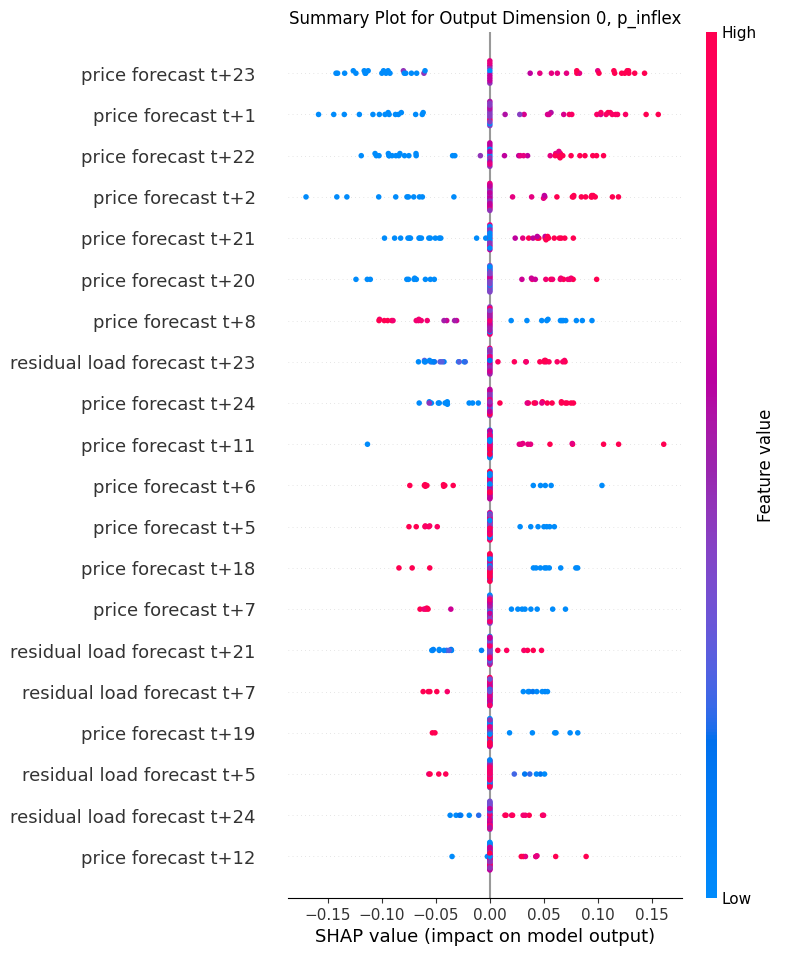

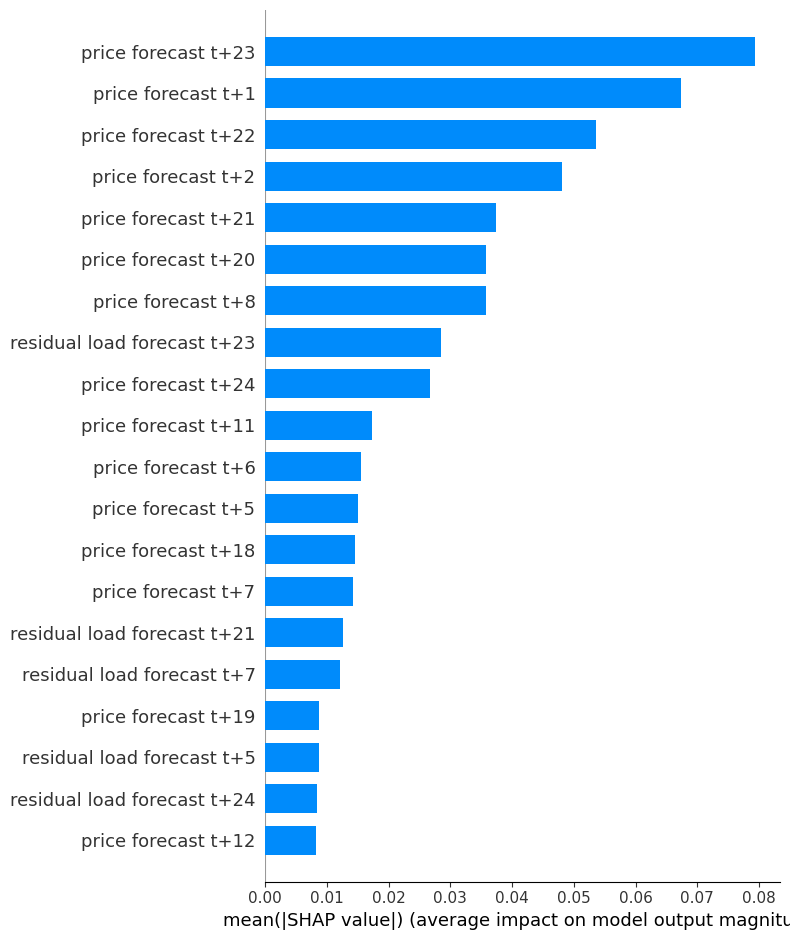

In [39]:
# Summary plot for the first output dimension
shap.summary_plot(
    shap_values[:, :, 0], X_test[:50], feature_names=feature_names, show=False
)
plt.title("Summary Plot for Output Dimension 0, p_inflex")
plt.show()


shap.summary_plot(
    shap_values[:, :, 0],
    X_test[:50],
    feature_names=feature_names,
    plot_type="bar",
    title="Summary Bar Plot for Output Dimension 0",
)

In [40]:
shap_values.shape

(50, 74, 1)

In [41]:
X_test.shape

(3883, 74)